# USER RATING PREDICTION USING NLP AND RESTAURANT RECOMMENDATION

## 1. INTRODUCTION

This dataset is a subset of Yelp’s businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp’s data and share their discoveries. In the dataset you’ll find information about businesses across 11 metropolitan areas in four countries.

Before we do any analysis, we have to understand :
1) what information the data has 
2) what relationship exists overall 
3) what can be done with different features. 

We have the following information for Yelp :

- Business - Contains business data including location data, and categories.  
- Attributes - Contains different business attributes
- Reviews - Contains full review text data including the user_id that wrote the review and the business_id the review is written for.  
- User - Conatins user data including the user's friend mapping and all the metadata associated with the user.  
- Checkin - Checkins on a business.  
- Tips - Contains tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.  
- Photos - Contains photo identification related information

In our notebook, we are mainly going to use busniess, user and review data. We are going to deep dive into the reviews of a user, perform text analysis, create a baseline model to predict the sentiment from the review and then compare it with another model where all the text pre-processing is done including removal of stopwords, punctuations and lemmatiation techniques to reflect if there is any significant change iin the sentiment prediction.

Also, we are then going to perform various types of recommendations based on the user ratings. We will first create a BaselineOnly model and then move ahead with various other modelling techniques for recommendations.

## 2. DATA PREPARATION - PACKAGE INSTALLATIONS, GOOGLE AUTHENTICATION, IMPORTING AND LOADING LIBRARIES AND DATA 

In [0]:
!pip install PyDrive

In [0]:
!pip install wordcloud

In [0]:
!pip install surprise

In [0]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import time
import nltk

In [0]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all
       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package brown to /root/nltk_data...
       |   Unzipping corpora/brown.zip.
       | Downloading package brown_tei to /root/nltk_data...
       |   Unzipping corpora/brown_tei.zip.
       | Downloading package cess_cat to /root/nltk_data...
       |   Unzipping corpora/cess_cat.zip.
       | Downloading package cess_esp to /root/nltk_data...
 

True

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
%%time
download = drive.CreateFile({'id': '1kU2JyKj_oLg1X_dGH-K3pTOQ_p-Dankx'})
download.GetContentFile('yelp.tar')

CPU times: user 5.37 s, sys: 12.7 s, total: 18.1 s
Wall time: 38.6 s


In [0]:
ls

adc.json  sample_data/  yelp.tar


In [0]:
%%time
import zipfile
with zipfile.ZipFile("yelp.tar","r") as zip_ref:
  print('extracting zip file')
  zip_ref.extractall("targetdir")

extracting zip file
CPU times: user 46.7 s, sys: 8.15 s, total: 54.8 s
Wall time: 1min 1s


In [0]:
ls

adc.json  sample_data/  targetdir/  yelp.tar


In [0]:
cd targetdir

/content/targetdir


In [0]:
ls

business.csv  checkin.csv  photos.csv  review.csv  tip.csv  user.csv


In [0]:
%%time
# basic imports
import pandas as pd
import os, sys
import math
import itertools
import datetime
import time
import gc
import numpy as np
from math import sqrt
import string
import warnings
warnings.filterwarnings('ignore')

#imports for visualisations
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import plot, iplot, init_notebook_mode
import networkx as nx
from wordcloud import WordCloud

# importing libraries for NLP
import nltk
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob, Word
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter

#importing libraries for modelling
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import correlation, cosine

#importing libraries for recommendations
from surprise import SVD, SVDpp, Dataset, accuracy, Reader, BaselineOnly, KNNBaseline, print_perf, evaluate
from surprise.model_selection import train_test_split, GridSearchCV, cross_validate


CPU times: user 808 ms, sys: 103 ms, total: 911 ms
Wall time: 2.12 s


In [0]:
# reading only 1,00,000 rows of all csv files due to limited GPU
%%time
user = pd.read_csv('yelp_data\\user_reduced.csv')
business = pd.read_csv('yelp_data\\business_reduced.csv')
checkin = pd.read_csv('yelp_data\\checkin_reduced.csv')
tip = pd.read_csv('yelp_data\\tip_reduced.csv')
review = pd.read_csv('yelp_data\\review_reduced.csv')

CPU times: user 4.88 s, sys: 518 ms, total: 5.39 s
Wall time: 5.65 s


## 3. DATA CLEANING AND EXPLORATORY DATA ANALYSIS

In [0]:
# Let us now explore the shape of each dataset
dnames = ['user', 'business', 'checkin', 'tip', 'review']
for n, d in zip(dnames, [user, business, checkin, tip, review]):
    print(n, d.shape)

user (100000, 22)
business (100000, 101)
checkin (100000, 169)
tip (100000, 5)
review (100000, 9)


In [0]:
# Let us peak into the columns for each dataset
for n, d in zip(dnames, [user, business, checkin, tip, review]):
    print('-------------------------------------------------{0}-------------------------------------------------'.format(n))
    print(d.head(1).T)
    gc.collect()

-------------------------------------------------user-------------------------------------------------
                                                                    0
yelping_since                                              2014-11-03
useful                                                              0
compliment_photos                                                   0
compliment_list                                                     0
compliment_funny                                                    0
compliment_plain                                                    1
review_count                                                        8
elite                                                              []
fans                                                                0
compliment_note                                                     0
funny                                                               0
compliment_writer                                        

In [0]:
# Get the count of columns which is present in more than 1 dataset
colnames = []
for d in [user, business, checkin, tip, review]:
    colnames.extend(d.columns)
colnames = pd.Series(colnames).value_counts().reset_index()
colnames.columns = ['colname', 'count']
colnames[colnames['count'] > 1]

,colname,count
0,business_id,4
1,user_id,3
2,cool,2
3,text,2
4,date,2
5,useful,2
6,funny,2
7,name,2
8,stars,2
9,review_count,2


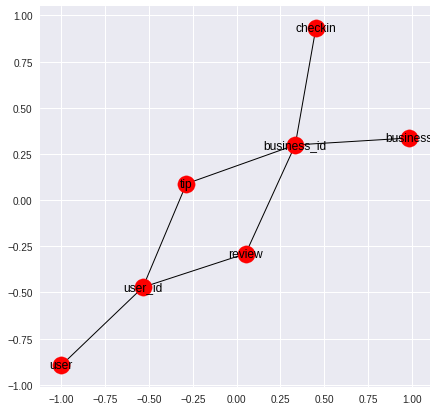

5847

In [0]:
# graph to understand the relationship between all datasets
G = nx.Graph()
fig, ax = plt.subplots(figsize=[7,7])
for n, d in zip(dnames, [user, business, checkin, tip, review]):
    _ = []
    for c in np.intersect1d(d.columns, ['business_id', 'user_id']):
        _.append([n, c])
    G.add_edges_from(_, label=n)
nx.draw_networkx(G, ax=ax)
plt.show()
gc.collect()

From the above graph, we see that the business_id is connected to business, checkin, review and tip datasets whereas user_id is connected to user, review and tip datasets. This information is further useful while we generate our recommendation system!

### 3.1 EXPLORING USER DATA

In [0]:
user.head(5)

,yelping_since,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count,elite,fans,compliment_note,...,compliment_cute,average_stars,user_id,compliment_more,friends,compliment_hot,cool,name,compliment_profile,compliment_cool
0,2014-11-03,0,0,0,0,1,8,[],0,0,...,0,4.67,oMy_rEb0UBEmMlu-zcxnoQ,0,"[u'cvVMmlU1ouS3I5fhutaryQ', u'nj6UZ8tdGo8YJ9lU...",0,0,Johnny,0,0
1,2013-09-24,0,0,0,0,0,10,[],0,0,...,0,3.70,JJ-aSuM4pCFPdkfoZ34q0Q,0,"[u'0njfJmB-7n84DlIgUByCNw', u'rFn3Xe3RqHxRSxWO...",0,0,Chris,0,0
2,2017-03-02,0,0,0,0,0,1,[],0,0,...,0,2.00,uUzsFQn_6cXDh6rPNGbIFA,0,[],0,0,Tiffy,0,0
3,2015-03-13,0,0,0,0,0,6,[],0,0,...,0,4.67,mBneaEEH5EMyxaVyqS-72A,0,[],0,0,Mark,0,0
4,2016-09-08,0,0,0,0,0,3,[],0,0,...,0,4.67,W5mJGs-dcDWRGEhAzUYtoA,0,[],0,0,Evelyn,0,0


In [0]:
# understanding the shape of user data
user.shape

(100000, 22)

In [0]:
# descriptive statistics
user.describe()

,useful,compliment_photos,compliment_list,compliment_funny,compliment_plain,review_count,fans,compliment_note,funny,compliment_writer,compliment_cute,average_stars,compliment_more,compliment_hot,cool,compliment_profile,compliment_cool
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,27.724610,1.172690,0.09840,3.913390,3.650380,23.643150,1.501520,1.704650,13.658100,1.374760,0.274640,3.719933,0.395450,2.938930,19.295040,0.268330,3.913390
std,592.594339,56.566653,4.86933,115.237802,87.433642,76.606091,13.798186,31.896656,351.025554,31.536854,11.364648,1.131898,8.894223,106.884751,599.818308,13.705523,115.237802
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.130000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.920000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.00000,0.000000,0.000000,16.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.670000,0.000000,0.000000,0.000000,0.000000,0.000000
max,98208.000000,12655.000000,1358.00000,23128.000000,10789.000000,3468.000000,1872.000000,4656.000000,47806.000000,6814.000000,2358.000000,5.000000,2062.000000,23173.000000,97378.000000,3740.000000,23128.000000


**Observation:**

1. The minimum value is 0 for everything except the average_stars. The minimum average_stars rating for a user is 1 and maximum value of that rating is 5

2. The average of the average_star rating for a user is 3.72 while the average time a user marked a business as useful is highest of other averages which is 27.72

3. The average of compliment_list, compliment_cute, compliment_more and compliment_profile is among the least which is less than 0.5

In [0]:
#check for complete user information
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 22 columns):
yelping_since         100000 non-null object
useful                100000 non-null int64
compliment_photos     100000 non-null int64
compliment_list       100000 non-null int64
compliment_funny      100000 non-null int64
compliment_plain      100000 non-null int64
review_count          100000 non-null int64
elite                 100000 non-null object
fans                  100000 non-null int64
compliment_note       100000 non-null int64
funny                 100000 non-null int64
compliment_writer     100000 non-null int64
compliment_cute       100000 non-null int64
average_stars         100000 non-null float64
user_id               100000 non-null object
compliment_more       100000 non-null int64
friends               100000 non-null object
compliment_hot        100000 non-null int64
cool                  100000 non-null int64
name                  99967 non-null object
comp

In [0]:
# converting a column in user dataframe from object to datetime format
user['yelping_since'] = pd.to_datetime(user['yelping_since'])

# converting objects to strings
#user['name'] = user['name'].astype('str')
#user['friends'] = user['friends'].astype(str)
#user['user_id'] = user['user_id'].astype('str')

In [0]:
# Look at the most active users based on the review count
user.sort_values('review_count', ascending=False).head(5).T

,48446,44813,89986,4584,32098
yelping_since,2009-09-03 00:00:00,2008-04-26 00:00:00,2005-07-02 00:00:00,2008-01-25 00:00:00,2007-05-13 00:00:00
useful,183,4450,833,29004,98208
compliment_photos,47,75,255,888,12655
compliment_list,2,5,40,158,1358
compliment_funny,310,631,1060,3327,23128
compliment_plain,271,916,740,5192,10789
review_count,3468,3118,2834,2666,2363
elite,"[2016, 2014, 2017, 2015]","[2013, 2014, 2016, 2015, 2017]","[2009, 2007, 2011, 2010, 2008, 2006]","[2014, 2013, 2012, 2009, 2015, 2011, 2017, 201...","[2007, 2009, 2008]"
fans,215,210,463,1872,573
compliment_note,191,344,348,1657,4656


In [0]:
# Let us look at the most popular user
user.sort_values('fans', ascending=False).head(5).T

,4584,44754,58934,64784,44762
yelping_since,2008-01-25 00:00:00,2008-05-12 00:00:00,2004-10-12 00:00:00,2008-08-22 00:00:00,2008-01-27 00:00:00
useful,29004,24252,49143,21751,48241
compliment_photos,888,402,2381,499,3591
compliment_list,158,156,98,87,219
compliment_funny,3327,2243,4373,2972,14180
compliment_plain,5192,5374,4661,5846,7094
review_count,2666,1622,1659,1989,331
elite,"[2014, 2013, 2012, 2009, 2015, 2011, 2017, 201...","[2015, 2017, 2009, 2014, 2008, 2013, 2010, 201...","[2016, 2017, 2011, 2009, 2014, 2015, 2013, 201...","[2013, 2010, 2009, 2012, 2014, 2015, 2016, 2011]","[2008, 2017, 2009, 2012, 2010, 2011]"
fans,1872,1252,1222,1084,826
compliment_note,1657,1397,1263,2043,1703


**OBSERVATION :**

From above, we see that the user with user id - 4584 is the most popular user with majority fans and is among the top 5 most active users who gave the reviews on yelp! 

In [0]:
# Let us look at the unique values of average_stars for the users
user['average_stars'].nunique()

380

In [0]:
# Let us check if all user_id's are unique
user['user_id'].is_unique

True

### 3.2 EXPLORING BUSINESS DATA

In [0]:
business.head(5)

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.HairSpecializesIn.coloring,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,hours.Friday,...,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,NaN,NaN,NaN,85044,7:30-17:00,NaN,NaN,NaN,NaN,7:30-17:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,15317,9:00-20:00,True,NaN,NaN,NaN,9:00-16:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,85017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,85282,10:00-21:00,NaN,NaN,NaN,NaN,10:00-21:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
4,False,False,NaN,44221,11:00-1:00,NaN,False,NaN,NaN,11:00-1:00,...,False,False,NaN,NaN,False,False,False,True,True,True


In [0]:
#Let us understand the shape of business data
business.shape

(100000, 101)

In [0]:
# Let us understand the descriptive statistics for business
business.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,100000.0,38.686014,5.359924,-36.086009,33.638617,36.148848,43.613911,89.999314
is_open,100000.0,0.839050,0.367487,0.000000,1.000000,1.000000,1.000000,1.000000
review_count,100000.0,29.831100,98.232933,3.000000,4.000000,8.000000,23.000000,7361.000000
stars,100000.0,3.633080,1.000037,1.000000,3.000000,3.500000,4.500000,5.000000
attributes.RestaurantsPriceRange2,59022.0,1.821575,0.685073,1.000000,1.000000,2.000000,2.000000,4.000000
longitude,100000.0,-92.458661,26.256084,-142.466650,-112.122696,-89.378127,-79.643233,14.092636


**OBSERVATION :**

1. The minimum and maximum values for is_open is 0 and 1 which suggests that it is a boolean value depicting whether a restaurent is open or not

2. The minimum and maximum values of stars for the business is in the range of 1-5 where the average rating for a particular business is 3.63

3. The minimum review_count for a business is 3 with maximum of about 7361 averaging around 29.83

In [0]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 101 entries, attributes.Ambience.divey to attributes.OutdoorSeating
dtypes: float64(4), int64(2), object(95)
memory usage: 77.1+ MB


In [0]:
# check for NaN's
business.isna().any()

attributes.Ambience.divey                      True
attributes.RestaurantsDelivery                 True
attributes.DogsAllowed                         True
postal_code                                    True
hours.Thursday                                 True
attributes.HairSpecializesIn.coloring          True
attributes.BestNights.sunday                   True
attributes.BYOB                                True
attributes.AgesAllowed                         True
hours.Friday                                   True
latitude                                      False
attributes.Alcohol                             True
attributes.Ambience.classy                     True
attributes.RestaurantsTableService             True
business_id                                   False
attributes.Ambience.touristy                   True
attributes.RestaurantsCounterService           True
attributes.Corkage                             True
attributes.RestaurantsGoodForGroups            True
categories  

In [0]:
# drop columns which have all null values
business.dropna(axis=1, how='all')

,attributes.Ambience.divey,attributes.RestaurantsDelivery,attributes.DogsAllowed,postal_code,hours.Thursday,attributes.HairSpecializesIn.coloring,attributes.BestNights.sunday,attributes.BYOB,attributes.AgesAllowed,hours.Friday,...,attributes.Caters,attributes.RestaurantsReservations,attributes.DietaryRestrictions.dairy-free,attributes.DietaryRestrictions.vegan,attributes.Ambience.romantic,attributes.Music.jukebox,attributes.Ambience.upscale,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,NaN,NaN,NaN,85044,7:30-17:00,NaN,NaN,NaN,NaN,7:30-17:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,15317,9:00-20:00,True,NaN,NaN,NaN,9:00-16:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,85017,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,85282,10:00-21:00,NaN,NaN,NaN,NaN,10:00-21:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
4,False,False,NaN,44221,11:00-1:00,NaN,False,NaN,NaN,11:00-1:00,...,False,False,NaN,NaN,False,False,False,True,True,True
5,NaN,False,False,70567,18:00-0:00,NaN,NaN,NaN,NaN,18:00-0:00,...,NaN,True,NaN,NaN,False,NaN,False,False,NaN,True
6,NaN,NaN,NaN,89128,8:00-17:00,NaN,NaN,NaN,NaN,8:00-17:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,89128,11:00-19:00,NaN,NaN,NaN,NaN,11:00-19:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN
8,NaN,NaN,NaN,15090,NaN,NaN,NaN,NaN,NaN,NaN,...,False,NaN,NaN,NaN,NaN,NaN,NaN,True,False,True
9,NaN,NaN,NaN,89014,9:00-18:00,NaN,NaN,NaN,NaN,9:00-18:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
business.shape  #shows all columns have some values in it as the shape remains same

(100000, 101)

In [0]:
# check for total count of NaN's
business.isnull().sum().sort_values(ascending=False)

attributes.DietaryRestrictions.kosher           99844
attributes.DietaryRestrictions.vegetarian       99844
attributes.DietaryRestrictions.vegan            99844
attributes.DietaryRestrictions.dairy-free       99844
attributes.DietaryRestrictions.gluten-free      99844
attributes.DietaryRestrictions.halal            99844
attributes.DietaryRestrictions.soy-free         99844
attributes.Open24Hours                          99803
attributes.RestaurantsCounterService            99784
attributes.AgesAllowed                          99768
attributes.Corkage                              99620
attributes.BYOB                                 99480
attributes.HairSpecializesIn.straightperms      99227
attributes.HairSpecializesIn.africanamerican    99227
attributes.HairSpecializesIn.asian              99227
attributes.BYOBCorkage                          99186
attributes.HairSpecializesIn.perms              99075
attributes.HairSpecializesIn.curly              99075
attributes.HairSpecializesIn

**OBSERVATION :**

From above we see that mainly the atttributes and opening hours columns of business have null values. As of now we will not fill all the columns having NaN's since all these columns are not required for further sentimental analysis and recommendation purpose. If required, we will then be filling out the NaN's or drop the columns if it is not significant.

In [0]:
# Let us check if all business Id's unique
business.business_id.is_unique

True

In [0]:
# Let us check if all business names are unique
business.name.is_unique

False

In [0]:
# Let us check for unique value of business rating
business['stars'].unique()

array([4. , 3. , 1.5, 3.5, 5. , 4.5, 2. , 2.5, 1. ])

In [0]:
# Let us check for total number of unique values of star rating for the business
business['stars'].nunique()

9

In [0]:
# Let us count the number of cities where the business is present
business.city.value_counts()

Las Vegas               15217
Phoenix                  9953
Toronto                  9948
Charlotte                4859
Scottsdale               4634
Pittsburgh               3749
Montréal                 3315
Mesa                     3233
Henderson                2773
Tempe                    2244
Edinburgh                2220
Chandler                 2054
Cleveland                2009
Madison                  1929
Glendale                 1811
Gilbert                  1692
Mississauga              1568
Stuttgart                1174
Markham                   886
Peoria                    870
North Las Vegas           783
Champaign                 769
North York                634
Scarborough               618
Surprise                  564
Richmond Hill             526
Brampton                  483
Concord                   481
Vaughan                   449
Goodyear                  434
                        ...  
Phoniex                     1
Mathews                     1
Westworld 

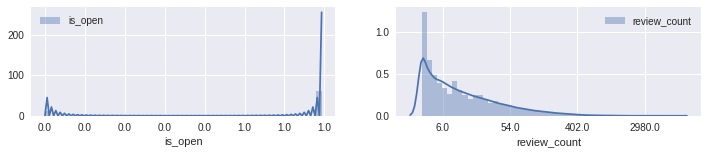

In [0]:
# Look at distribution for numeric variables
business_desc = business.dtypes.reset_index()
business_desc.columns = ['variable', 'type']
cols = business_desc[business_desc['type']=='int64']['variable']
fig, ax = plt.subplots(math.ceil(len(cols)/2), 2, figsize=[12, math.ceil(len(cols)/2)*2])
for ax_, v in zip(ax[:len(cols)], cols):
    sns.distplot(np.log1p(business[v]), ax=ax_, label=v)
    ax_.set_xticklabels(np.expm1(ax_.get_xticks()).round())
    ax_.legend()
plt.show()

In [0]:
# Let us look at the count on businesses in the neighborhood, city and state
cols = ['neighborhood', 'city', 'state']
for c in cols:
    print(business[c].value_counts(normalize=True).head())

Westside         0.051106
Southeast        0.047080
The Strip        0.040788
Spring Valley    0.038775
Downtown         0.034699
Name: neighborhood, dtype: float64
Las Vegas     0.15217
Phoenix       0.09953
Toronto       0.09948
Charlotte     0.04859
Scottsdale    0.04634
Name: city, dtype: float64
AZ    0.291933
NV    0.189982
ON    0.174192
NC    0.074531
OH    0.072081
Name: state, dtype: float64


In [0]:
# Let us look at the top 50 reviewed business
business[['name','business_id', 'review_count', 'city', 'stars']].sort_values(ascending=False, by="review_count")[0:50]

,name,business_id,review_count,city,stars
97944,Mon Ami Gabi,4JNXUYY8wbaaDmk3BPzlWw,7361,Las Vegas,4.0
69993,Wicked Spoon,K7lWdNUhCbcnEvI0NhGewg,5950,Las Vegas,3.5
81212,Gordon Ramsay BurGR,cYwJA2A6I12KNkm2rtXd5g,5447,Las Vegas,4.0
19191,Hash House A Go Go,f4x1YBxkLrZg652xt2KR5g,4774,Las Vegas,4.0
80590,The Buffet,2weQS-RnoOBhb1KsHKyoSQ,4018,Las Vegas,3.5
21006,Serendipity 3,eoHdUeQDNgQ6WYEnP2aiRw,3910,Las Vegas,3.0
93038,The Buffet at Bellagio,ujHiaprwCQ5ewziu0Vi9rw,3838,Las Vegas,3.5
26748,ARIA Resort & Casino,SMPbvZLSMMb7KU76YNYMGg,3794,Las Vegas,3.5
80626,The Cosmopolitan of Las Vegas,5LNZ67Yw9RD6nf4_UhXOjw,3772,Las Vegas,4.0
25096,Secret Pizza,iCQpiavjjPzJ5_3gPD5Ebg,3741,Las Vegas,4.0


In [0]:
# Let us look at the cities with most reviews and best ratings for their business
city_business_reviews = business[['city', 'review_count', 'stars']].groupby(['city']).\
agg({'review_count': 'sum', 'stars': 'mean'}).sort_values(by='review_count', ascending=False)
city_business_reviews.head(10)

,review_count,stars
city,,
Las Vegas,905346,3.718900
Phoenix,326508,3.670150
Toronto,250016,3.487988
Scottsdale,171696,3.947669
Charlotte,132223,3.569356
Pittsburgh,107171,3.613764
Henderson,99668,3.786873
Tempe,86596,3.736631
Mesa,74290,3.640736


Text(0.5,1,'Top 50 cities by reviews')

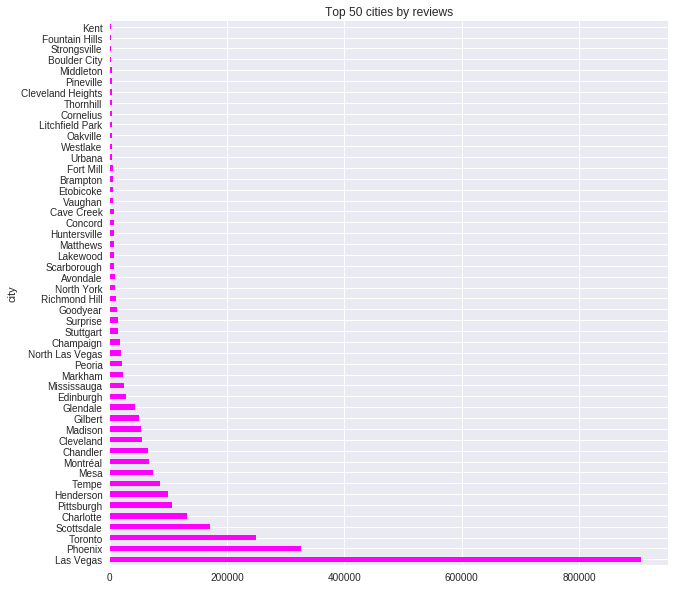

In [0]:
# visualising the top 50 cities in terms of review counts
city_business_reviews['review_count'][0:50].plot(kind='barh', stacked=False, figsize=[10,10], \
                                                 colormap='spring')
plt.title('Top 50 cities by reviews')

Text(0.5,1,'Cities with greater than 50k reviews ranked by average stars')

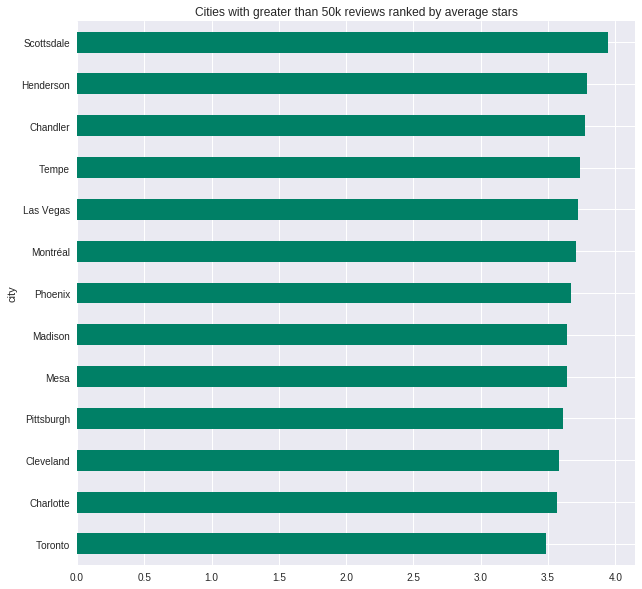

In [0]:
# visualising cities with greater than 50k reviews ranked by stars
city_business_reviews[city_business_reviews.review_count > 50000]['stars'].sort_values()\
.plot(kind='barh', stacked=False, figsize=[10,10], colormap='summer')
plt.title('Cities with greater than 50k reviews ranked by average stars')

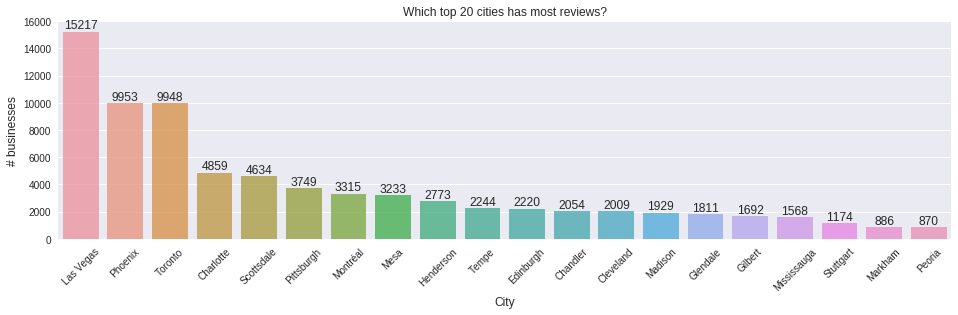

680

In [0]:
# Get the distribution of the ratings
x=business['city'].value_counts().sort_values(ascending=False)
x=x.iloc[0:20]
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Which top 20 cities has most reviews?")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)
plt.ylabel('# businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
gc.collect()

Number of city listed 876
Number of state listed 61


494

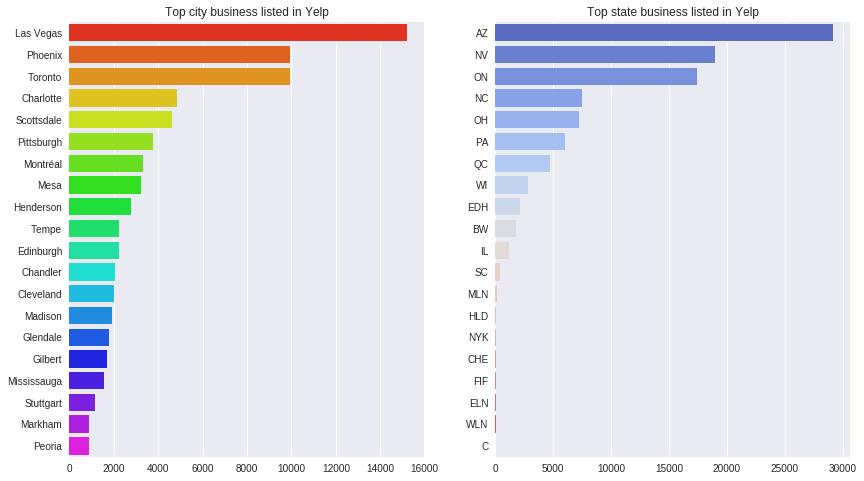

In [0]:
print('Number of city listed',business['city'].nunique())
print('Number of state listed',business['state'].nunique())

f,ax = plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()

cnt = business['city'].value_counts()[:20].to_frame()
sns.barplot(cnt['city'], cnt.index, palette = 'gist_rainbow', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Top city business listed in Yelp')

cnt = business['state'].value_counts()[:20].to_frame()
sns.barplot(cnt['state'], cnt.index, palette = 'coolwarm', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Top state business listed in Yelp');
gc.collect()

**Observations** :

- There are 1093 city listed in yelp.com
- City Las Vegas is top list in business listing in Yelp.com followed by - Phoniex,Toronto etc..
- There are 67 state listed in yelp.com
- State AZ is top in the list of Yelp.com
- There are few states having very few business listing

11008

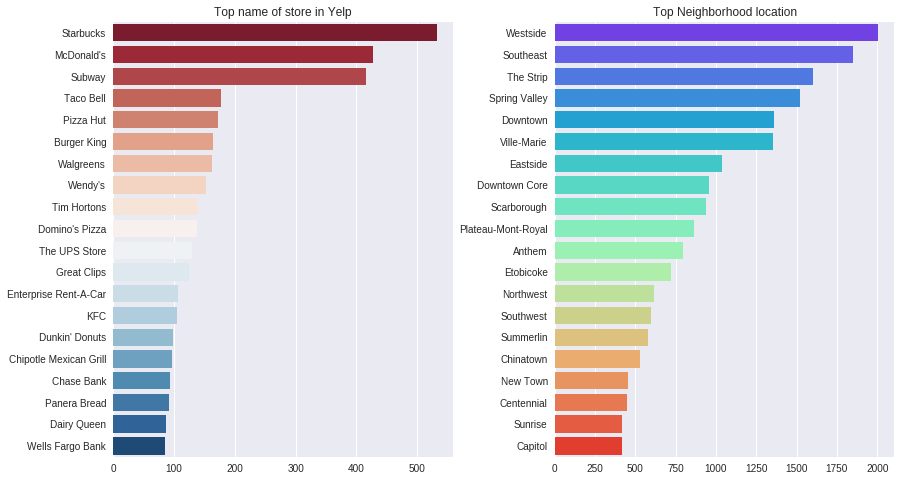

In [0]:
f,ax = plt.subplots(1,2, figsize=(14,8))
ax1,ax2, = ax.flatten()

cnt = business['name'].value_counts()[:20].to_frame()
sns.barplot(cnt['name'], cnt.index, palette = 'RdBu', ax =ax1)
ax1.set_xlabel('')
ax1.set_title('Top name of store in Yelp')

cnt = business['neighborhood'].value_counts()[:20].to_frame()
sns.barplot(cnt['neighborhood'], cnt.index, palette = 'rainbow', ax =ax2)
ax2.set_xlabel('')
ax2.set_title('Top Neighborhood location')

plt.subplots_adjust(wspace=0.3)
gc.collect()

**Observation** :

- 'Starbucks' is top in list
- 'Chase bank' and 'Bank of America' is in top 20
- There are many missing values in 'Neighborhood' varaible in data set
- 'Westside' location tops the list

In [0]:
# Let us look into different categories of business
business['categories'].head(5)

0    [u'Dentists', u'General Dentistry', u'Health &...
1    [u'Hair Stylists', u'Hair Salons', u"Men's Hai...
2    [u'Departments of Motor Vehicles', u'Public Se...
3                     [u'Sporting Goods', u'Shopping']
4    [u'American (New)', u'Nightlife', u'Bars', u'S...
Name: categories, dtype: object

In [0]:
# Let us look at the count of unique categories
print(business['categories'].nunique())

# Let us check the most frequent categories
business['categories'].value_counts().head(20)

46715


[u'Restaurants', u'Pizza']                 585
[u'Pizza', u'Restaurants']                 568
[u'Food', u'Coffee & Tea']                 558
[u'Mexican', u'Restaurants']               555
[u'Coffee & Tea', u'Food']                 546
[u'Nail Salons', u'Beauty & Spas']         535
[u'Beauty & Spas', u'Nail Salons']         520
[u'Chinese', u'Restaurants']               506
[u'Restaurants', u'Chinese']               503
[u'Restaurants', u'Mexican']               503
[u'Beauty & Spas', u'Hair Salons']         493
[u'Hair Salons', u'Beauty & Spas']         440
[u'Restaurants', u'Italian']               366
[u'Italian', u'Restaurants']               334
[u'Auto Repair', u'Automotive']            327
[u'Grocery', u'Food']                      304
[u'Automotive', u'Auto Repair']            303
[u'Food', u'Grocery']                      286
[]                                         279
[u'Food', u'Ice Cream & Frozen Yogurt']    241
Name: categories, dtype: int64

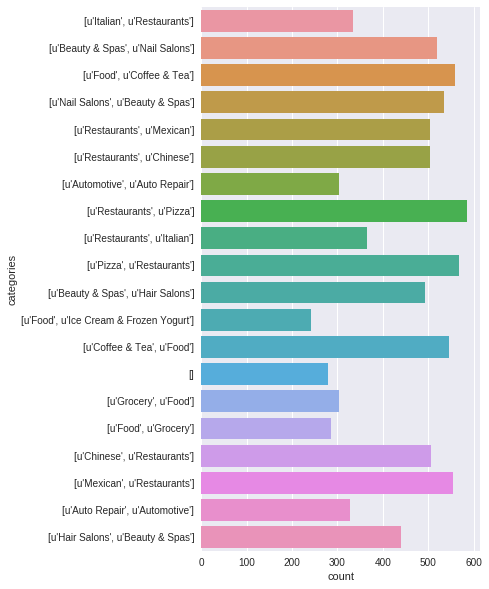

6138

In [0]:
#Data visualisation for most frequent categories
fig, ax = plt.subplots(figsize=[5,10])
sns.countplot(data=business[business['categories'].isin(
    business['categories'].value_counts().head(20).index)],
                              y='categories', ax=ax)
plt.show()
gc.collect()

70

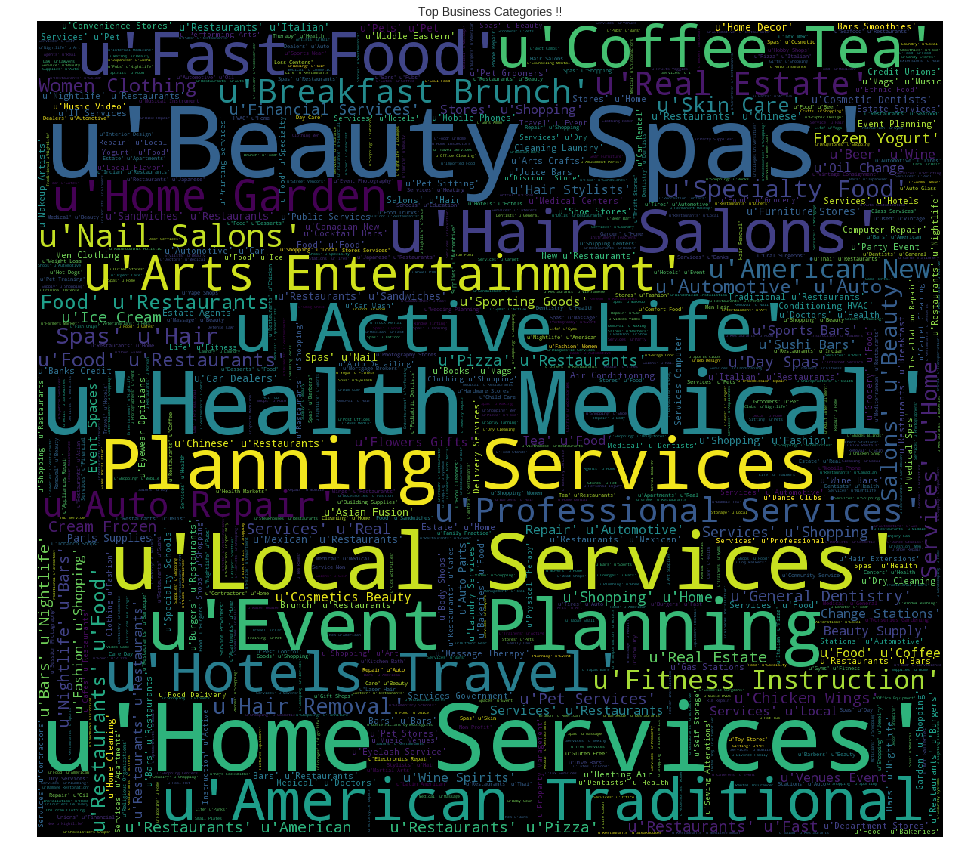

In [0]:
# Wordcloud for business categories
cloud = WordCloud(width=1200, height= 1080,max_words= 1000).generate(' '.join(business['categories'].astype(str)))
plt.figure(figsize=(20, 15))
plt.title('Top Business Categories !!')
plt.imshow(cloud)
plt.axis('off');
gc.collect()

**Observation :**

Home Services is the top business in yelp followed by Health Medical, Planning Services, Local Services and Event Planning.

In [0]:
# Let us get the distribution of stars in business data
business['stars'].value_counts()

4.0    19175
3.5    18565
5.0    15779
4.5    14063
3.0    13293
2.5     9283
2.0     5310
1.5     2427
1.0     2105
Name: stars, dtype: int64

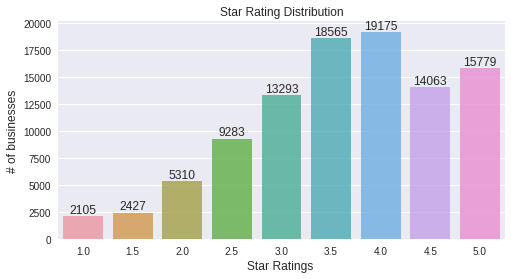

8415

In [0]:
#Get the distribution of the ratings
x=business['stars'].value_counts().sort_index()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('# of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
gc.collect()

**Observation :**

1. Maximum number of user have rated a 4 star rating to the businesses
2. 1 star rating to businessess are the least
3. Majority of star rating given to businesses are above 3 stars which signifies that most businesses have got a positive feedback from users

Median review count 8.0


269

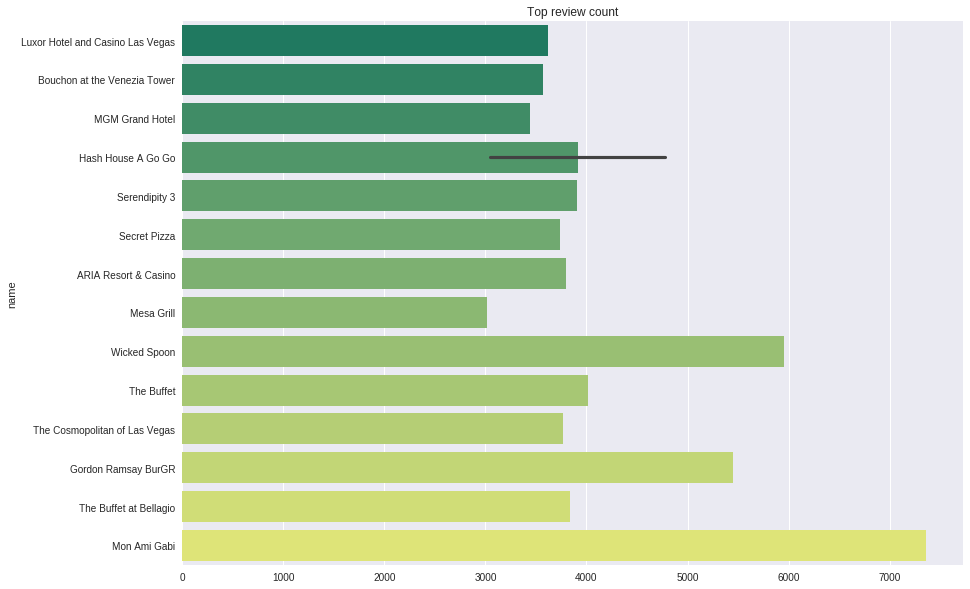

In [0]:
# Let us now look at the businesses who got more than 3k reviews
print('Median review count',business['review_count'].median())
plt.figure(figsize = (14,10))
sns.barplot(business[business['review_count'] >3000]['review_count'],business[business['review_count'] >3000]['name'],
           palette = 'summer')
plt.xlabel('')
plt.title('Top review count');
gc.collect()

**Observation :**

- The review count for 'Mon Ami Gabi tops the list, which has more than 7000 reviews.
- The median review count is 8 for businesses

In [0]:
# Let us check how many businesses are open and how many are closed
business['is_open'].value_counts()

1    83905
0    16095
Name: is_open, dtype: int64

4464

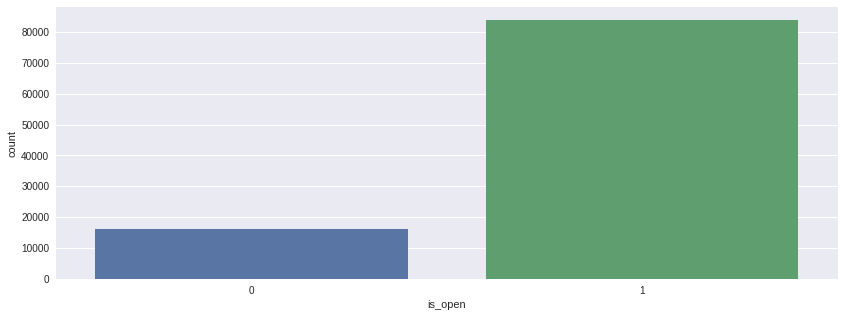

In [0]:
plt.figure(figsize=(14,5))
sns.countplot(business['is_open'])
gc.collect()

**Observation :**

1. Majority of the businesses are open i.e more than 80,000
2. Few number of businesses i.e around 15,000 remain closed

### 3.3 EXPLORING REVIEW DATA

In [0]:
#understand reveiw data
review.head(5).T

,0,1,2,3,4
funny,0,0,0,0,0
user_id,bv2nCi5Qv5vroFiqKGopiw,bv2nCi5Qv5vroFiqKGopiw,bv2nCi5Qv5vroFiqKGopiw,bv2nCi5Qv5vroFiqKGopiw,bv2nCi5Qv5vroFiqKGopiw
review_id,v0i_UHJMo_hPBq9bxWvW4w,vkVSCC7xljjrAI4UGfnKEQ,n6QzIUObkYshz4dz2QRJTw,MV3CcKScW05u5LVfF6ok0g,IXvOzsEMYtiJI0CARmj77Q
text,"Love the staff, love the meat, love the place....",Super simple place but amazing nonetheless. It...,Small unassuming place that changes their menu...,Lester's is located in a beautiful neighborhoo...,Love coming here. Yes the place always needs t...
business_id,0W4lkclzZThpx3V65bVgig,AEx2SYEUJmTxVVB18LlCwA,VR6GpWIda3SfvPC-lg9H3w,CKC0-MOWMqoeWf6s-szl8g,ACFtxLv8pGrrxMm6EgjreA
stars,5,5,5,5,4
date,2016-05-28,2016-05-28,2016-05-28,2016-05-28,2016-05-28
useful,0,0,0,0,0
cool,0,0,0,0,0


In [0]:
review.shape

(100000, 9)

In [0]:
review.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
funny,100000,NaN,NaN,NaN,0.46506,2.34841,0,0,0,0,447
user_id,100000,24660,YwaKGmRNnSa3R3N4Hf9jLw,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_id,100000,100000,eFE-A3OC0Hc1MP6qbXzpqA,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,100000,99954,"They hit my car with a trash can, I complained...",4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
business_id,100000,45600,4JNXUYY8wbaaDmk3BPzlWw,122,NaN,NaN,NaN,NaN,NaN,NaN,NaN
stars,100000,NaN,NaN,NaN,3.74494,1.41655,1,3,4,5,5
date,100000,3744,2017-12-10,171,NaN,NaN,NaN,NaN,NaN,NaN,NaN
useful,100000,NaN,NaN,NaN,1.33357,5.75888,0,0,0,2,1456
cool,100000,NaN,NaN,NaN,0.54787,2.17636,0,0,0,1,245


In [0]:
review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
funny          100000 non-null int64
user_id        100000 non-null object
review_id      100000 non-null object
text           100000 non-null object
business_id    100000 non-null object
stars          100000 non-null int64
date           100000 non-null object
useful         100000 non-null int64
cool           100000 non-null int64
dtypes: int64(4), object(5)
memory usage: 6.9+ MB


In [0]:
#check for null values
review.isnull().sum() # no null values

funny          0
user_id        0
review_id      0
text           0
business_id    0
stars          0
date           0
useful         0
cool           0
dtype: int64

7928

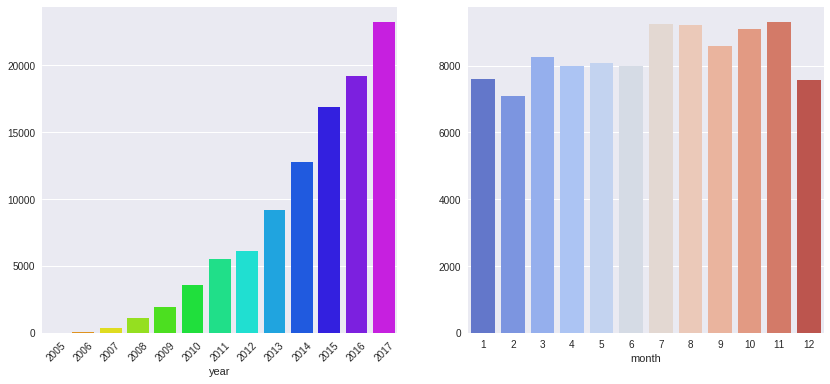

In [0]:
# Review distribution according to the year and month
review['date'] = pd.to_datetime(review['date'])
review['year'] = review['date'].dt.year
review['month'] = review['date'].dt.month

f,ax = plt.subplots(1,2, figsize = (14,6))
ax1,ax2 = ax.flatten()
cnt = review.groupby('year').count()['stars'].to_frame()
sns.barplot(cnt.index, cnt['stars'],palette = 'gist_rainbow', ax=ax1)
ax1.set_ylabel('')

for ticks in ax1.get_xticklabels():
    ticks.set_rotation(45)

cnt = review.groupby('month').count()['stars'].to_frame()
sns.barplot(cnt.index, cnt['stars'],palette = 'coolwarm', ax = ax2)
ax2.set_ylabel('')
gc.collect()

**Observation :**

1. Above figure shows that 2015 onwards the number of users providing the reviews on yelp increased drastically

2. In the month of November maximum reveiws are given by users which implies most of the users in the month of November are involved in yelp businesses

90

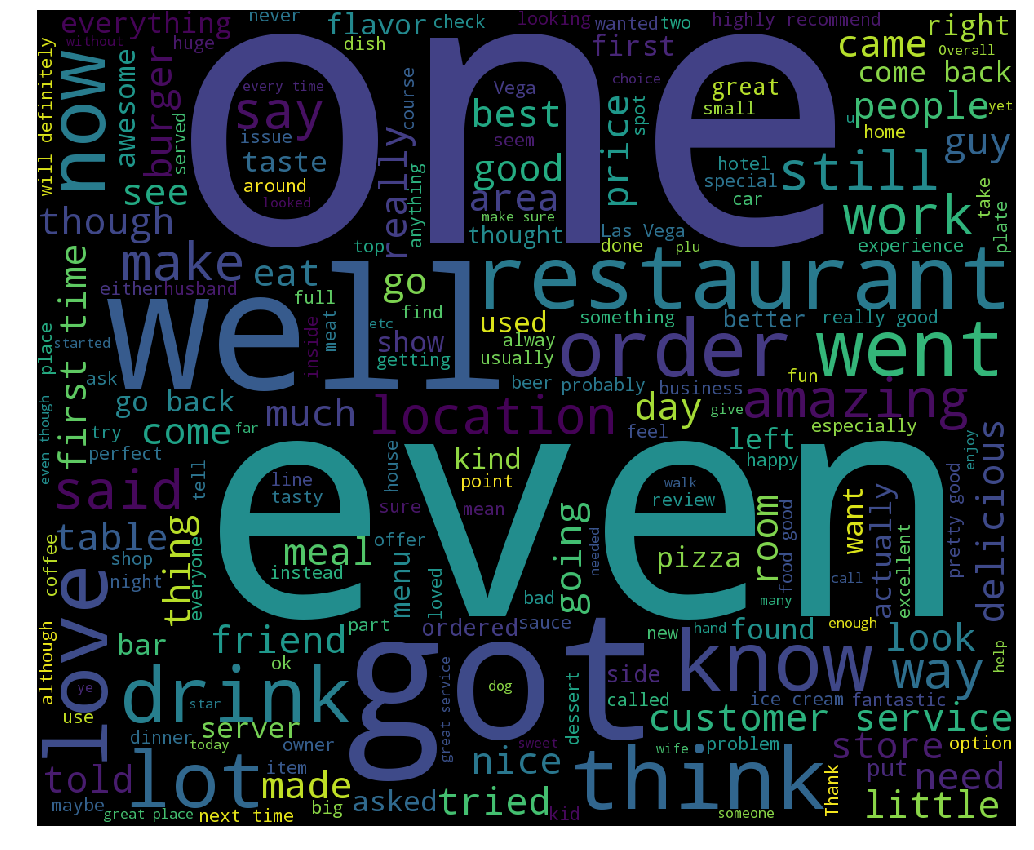

In [0]:
# Word cloud for review text
cloud = WordCloud(width=1200, height= 1000,max_words= 200).generate(' '.join(review['text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');
gc.collect()

**Observation :**

Right now the baove wordcloud does not make sense since the text review has lots of stop words which has high number of occurance. But ignoring the stopwords, we see words like restaurent, love and drink are used majority of the times which implies that most of the reveiws are related to restaurants or food related business.

## 3.4 EXPLORING TIP DATA

In [0]:
tip.head(5)

,user_id,text,business_id,likes,date
0,zcTZk7OG8ovAmh_fenH21g,Get here early enough to have dinner.,tJRDll5yqpZwehenzE2cSg,0,2012-07-15
1,ZcLKXikTHYOnYt5VYRO5sg,Great breakfast large portions and friendly wa...,jH19V2I9fIslnNhDzPmdkA,0,2015-08-12
2,oaYhjqBbh18ZhU0bpyzSuw,Nice place. Great staff. A fixture in the tow...,dAa0hB2yrnHzVmsCkN4YvQ,0,2014-06-20
3,ulQ8Nyj7jCUR8M83SUMoRQ,Happy hour 5-7 Monday - Friday,dAa0hB2yrnHzVmsCkN4YvQ,0,2016-10-12
4,ulQ8Nyj7jCUR8M83SUMoRQ,"Parking is a premium, keep circling, you will ...",ESzO3Av0b1_TzKOiqzbQYQ,0,2017-01-28


In [0]:
# let us sxplore the shape of tip data
tip.shape

(100000, 5)

In [0]:
tip.dtypes

user_id        object
text           object
business_id    object
likes           int64
date           object
dtype: object

In [0]:
#descriptive statistics
tip.describe().T

,count,mean,std,min,25%,50%,75%,max
likes,100000.0,0.01919,0.156595,0.0,0.0,0.0,0.0,7.0


In [0]:
tip.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
user_id        100000 non-null object
text           100000 non-null object
business_id    100000 non-null object
likes          100000 non-null int64
date           100000 non-null object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


2318

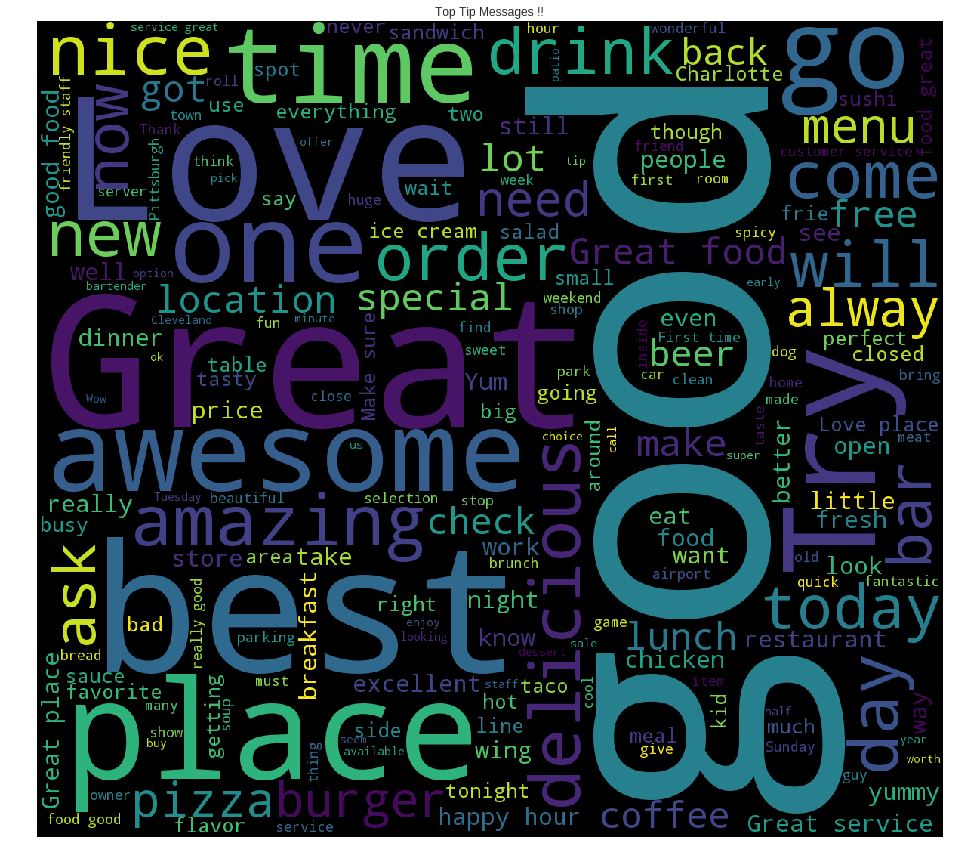

In [0]:
# Word cloud for the text in tip data
cloud = WordCloud(width=1200, height= 1080,max_words= 200).generate(' '.join(tip['text'].astype(str)))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.title('Top Tip Messages !!')
plt.axis('off');
gc.collect()

**Observation :**

Good is the most used word in the tip text data followed by great, best, awesome and love. This shows that majority of the text written by user while giving the tip is positive for a particular business

## 4. CONCLUSION

After we have explored the data  after transformation and pre-processing of the Yelp dataset, we move on to predict the ratings provided by a user for a business based on the review. We will also recommend restaurants based on content and collaborative filtering.

## The MIT License

Copyright 2019 Ami Gandhi, Shreyansh Singh, Pranav Swaminathan

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.